In [ ]:
import jax
jax.config.update('jax_enable_x64',True)
jax.config.update("jax_default_device",jax.devices()[1])
import jax.numpy as jnp
import diffrax

import matplotlib.pyplot as plt
plt.style.use('ggplot')
from jax.random import key

from jsindy.sindy_model import JSINDyModel
from jsindy.trajectory_model import CholDataAdaptedRKHSInterpolant
from jsindy.dynamics_model import FeatureLinearModel,PolyLib
from jsindy.optim import AlternatingActiveSetLMSolver, LMSettings,AnnealedAlternatingActiveSetLMSolver
from jsindy.optim.solvers.alt_active_set_lm_solver import pySindySparsifier,NoSparsifier
from pysindy import STLSQ,SR3,MIOSR
import jsindy
from numpy import loadtxt
from tqdm.auto import tqdm
plt.rcParams["font.family"] = 'serif'


In [5]:
t1 = 10
x0 = jnp.array([2,0.])
def f(t,x,args):
    return jnp.array([- 0.1*x[0]**3 + 2*x[1]**3,- 0.1*x[1]**3 -2*x[0]**3])
ode = diffrax.ODETerm(f)
step_control = diffrax.PIDController(rtol = 1e-7,atol =1e-7)
solver = diffrax.Tsit5()
save_at = diffrax.SaveAt(dense = True)

sol = diffrax.diffeqsolve(ode,solver,0.,20.,dt0 = 0.005,y0 = x0,saveat = save_at,stepsize_controller=step_control)

dt_train = 0.05

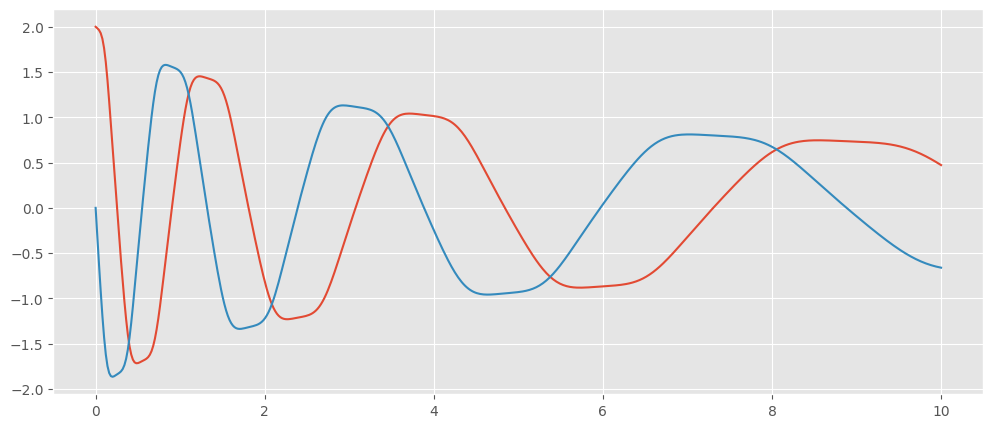

In [6]:
t_grid = jnp.linspace(0,t1,500)
x_vals = jax.vmap(sol.evaluate)(t_grid)

plt.figure(figsize=(12,5))
plt.plot(t_grid,x_vals[:,0])
plt.plot(t_grid,x_vals[:,1])

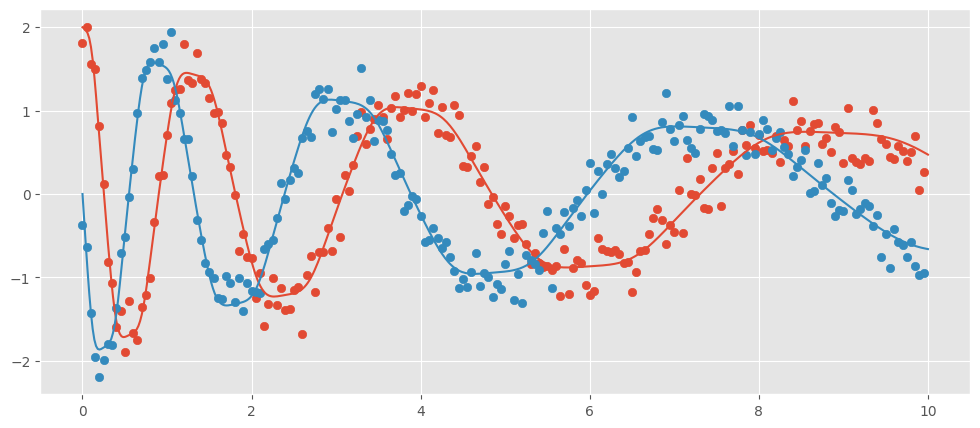

In [7]:
t_train = jnp.arange(0,t1,dt_train)
x_train_true = jax.vmap(sol.evaluate)(t_train)

noise_sigma = 0.2
x_train = x_train_true + noise_sigma * jax.random.normal(key(111),(x_train_true.shape))

plt.figure(figsize=(12,5))
plt.scatter(t_train,x_train[:,0])
plt.scatter(t_train,x_train[:,1])
plt.plot(t_grid,x_vals[:,0])
plt.plot(t_grid,x_vals[:,1])
plt.show()


In [8]:
true_theta = jnp.array(
    [[ 0.        ,  0.        ],
    [ 0.        , 0.    ],
    [0. ,  0.        ],
    [ 0.        ,  0.        ],
    [ 0.        ,  0.        ],
    [ 0.        ,  0.        ],
    [-0.1, -2.],
    [ 0.        ,  0.        ],
    [ 0.        ,  0.        ],
    [ 2., -0.1]])

In [ ]:
noise_vals = jnp.array([0.02,0.04,0.08,0.16,0.32,0.64])

In [16]:
from pysindy import EnsembleOptimizer
from pysindy.differentiation import SmoothedFiniteDifference
import pysindy as ps
import numpy as np

In [31]:
library = ps.PolynomialLibrary(3)

optimizer = EnsembleOptimizer(
    STLSQ(threshold = 0.05,alpha = 10.),
    bagging=True,
    n_models = 200)

diff_method = ps.SmoothedFiniteDifference()

ps_model = ps.SINDy(
    feature_library=library,
    optimizer=optimizer,
    differentiation_method=diff_method
    )

num_repeats = 32
all_ps_theta_errors = np.zeros((num_repeats,len(noise_vals)))
all_keys = jax.random.split(key(3184),num_repeats)

for repetition in tqdm(range(num_repeats)):
    # print(repetition)
    for s,noise_sigma in enumerate(noise_vals):
        x_train = x_train_true + noise_sigma * jax.random.normal(all_keys[repetition],(x_train_true.shape))
        ps_model.fit(np.array(x_train),np.array(t_train))
        theta = ps_model.coefficients().T
        all_ps_theta_errors[repetition,s] = (
            jnp.linalg.norm(true_theta - theta)/jnp.linalg.norm(true_theta))
all_ps_theta_errors = jnp.array(all_ps_theta_errors)

import warnings
ode_lib = ps.WeakPDELibrary(
    function_library=library,
    spatiotemporal_grid=t_train,
    # is_uniform=True,
    K=250,
)
# optimizer = EnsembleOptimizer(
#     STLSQ(threshold = 0.05,alpha = 10.),
#     bagging=True,
#     n_models = 200)
optimizer = STLSQ(threshold = 0.05,alpha = 10.)
weak_model = ps.SINDy(feature_library=ode_lib, optimizer=optimizer)

num_repeats = 32
all_weak_theta_errors = np.zeros((num_repeats,len(noise_vals)))
all_keys = jax.random.split(key(3184),num_repeats)
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    for repetition in tqdm(range(num_repeats)):
        for s,noise_sigma in enumerate(noise_vals):
            x_train = x_train_true + noise_sigma * jax.random.normal(all_keys[repetition],(x_train_true.shape))
            weak_model.fit(np.array(x_train),np.array(t_train))
            theta = weak_model.coefficients().T
            all_weak_theta_errors[repetition,s] = (
                jnp.linalg.norm(true_theta - theta)/jnp.linalg.norm(true_theta))
all_weak_theta_errors = jnp.array(all_weak_theta_errors)

optimizer = EnsembleOptimizer(
    STLSQ(threshold = 0.05,alpha = 10.),
    bagging=True,
    n_models = 200)
weak_ensemble_model = ps.SINDy(feature_library=ode_lib, optimizer=optimizer)

num_repeats = 32
all_weak_ensemble_theta_errors = np.zeros((num_repeats,len(noise_vals)))
all_keys = jax.random.split(key(3184),num_repeats)
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    for repetition in tqdm(range(num_repeats)):
        for s,noise_sigma in enumerate(noise_vals):
            x_train = x_train_true + noise_sigma * jax.random.normal(all_keys[repetition],(x_train_true.shape))
            weak_ensemble_model.fit(np.array(x_train),np.array(t_train))
            theta = weak_ensemble_model.coefficients().T
            all_weak_ensemble_theta_errors[repetition,s] = (
                jnp.linalg.norm(true_theta - theta)/jnp.linalg.norm(true_theta))
all_weak_ensemble_theta_errors = jnp.array(all_weak_ensemble_theta_errors)

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

In [ ]:
all_theta_errors = jnp.load('all_theta_errors.npy')
all_x_errors = jnp.load('all_x_errors.npy')

mean_jsindy_theta = jnp.mean(all_theta_errors,axis=0)
mean_jsindy_x = jnp.mean(all_x_errors,axis=0)


jsindy_ensemble_theta = jnp.load('exp2/all_theta_errors.npy')
jsindy_ensemble_x = jnp.load('exp2/all_x_errors.npy')

mean_ensemble_theta = jnp.mean(jsindy_ensemble_theta,axis=0)
mean_ensemble_x = jnp.mean(jsindy_ensemble_x,axis=0)


odr_coef_error = jnp.array(loadtxt("coef_error.csv",delimiter = ','))
odr_x_error = jnp.array(loadtxt("x_error.csv",delimiter = ','))

odr_mean_x = jnp.mean(odr_coef_error,axis=0)
odr_mean_coef = jnp.mean(odr_x_error,axis=0)
odr_median_coef = jnp.median(odr_x_error[:-1],axis=0)


mean_weak_error = jnp.mean(all_weak_theta_errors,axis=0)
mean_sindy_error = jnp.mean(all_ps_theta_errors,axis=0)

mean_weak_ensemble = jnp.mean(all_weak_ensemble_theta_errors,axis=0)


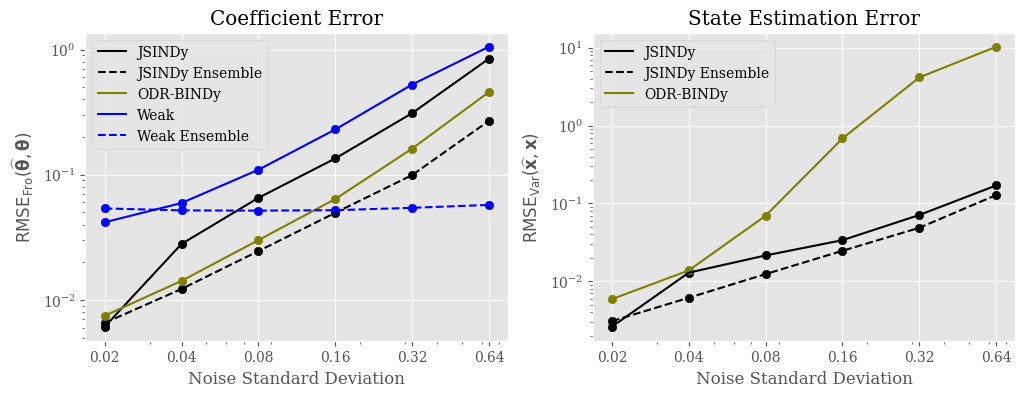

In [66]:
noise_axis_vals = noise_vals#/jnp.std(x_train_true)
def plot_result(values,color=None,label=None,ls = None):
    plt.plot(noise_axis_vals,values,c=color,label = label,ls = ls)
    plt.scatter(noise_axis_vals,values,c=color)

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)

plot_result(mean_jsindy_theta,'black','JSINDy')
plot_result(mean_ensemble_theta,'black','JSINDy Ensemble',ls = '--')
plot_result(odr_mean_coef,'olive','ODR-BINDy')
plot_result(mean_weak_error,'blue','Weak')
plot_result(mean_weak_ensemble,'blue','Weak Ensemble',ls = '--')
plt.title("Coefficient Error")
# plot_result(mean_sindy_error,'brown','Basic Ensemble')
plt.xscale('log')
plt.yscale('log')

plt.xticks(noise_axis_vals,noise_axis_vals)

plt.legend()
# plt.savefig('nonlin-osc-theta.pdf')
plt.xlabel("Noise Standard Deviation")
# plt.ylabel(r"${\operatorname{RMSE}_{\text{Fro}}(\widehat{\vect{\theta}},\vect{\theta})}$")
plt.ylabel(r"$\mathrm{RMSE}_{\mathrm{Fro}}(\widehat{\mathbf{\theta}},\mathbf{\theta})$",labelpad = 5)

plt.subplot(1,2,2)
plt.title("State Estimation Error")
plot_result(mean_jsindy_x,'black','JSINDy')
plot_result(mean_ensemble_x,'black','JSINDy Ensemble',ls = '--')
plot_result(odr_mean_x,'olive','ODR-BINDy')
plt.xscale('log')
plt.yscale('log')
plt.xticks(noise_axis_vals,noise_axis_vals)

plt.legend()

plt.xlabel("Noise Standard Deviation")
# plt.ylabel(r"${\operatorname{RMSE}_{\text{Fro}}(\widehat{\vect{\theta}},\vect{\theta})}$")
plt.ylabel(r"$\mathrm{RMSE}_{\mathrm{Var}}(\widehat{\mathbf{x}},\mathbf{x})$",labelpad = 5)
plt.savefig('nonlin-osc.pdf')
plt.show()